References:\
    https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/ (pickle)\
    https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de(custom Imputer)

# Business Problem

>According to WHO, one out of six people lack access to safe drinking water in Tanzania (WHO/UNICEF, 2004).
>-https://projectzawadi.org/water-shortage/

>It is estimated that Tanzania spends 70 per cent of its health budget on preventable WASH (Water, Sanitation and Hygiene) ->related diseases as the majority of the population does not have access to improved sanitation, and close to half of the >population does not have access to clean drinking water.
>-https://www.unicef.org/tanzania/what-we-do/wash

Resolving the water poverty crisis has been an ongoing agenda for the Tanzanian government water body for decades now. The Tanzanian government in conjunction with various charity efforts and the villages themselves has made major strides in improving the life of the Tanzanian people.

>In the year 2000, 73 percent of Tanzanians were living without basic access to safe water. The most up-to-date numbers from >2017 show that the percentage was nearly halved and continues to fall.
>-https://lifewater.org/blog/tanzania-water-crisis-facts/

Looking at past water well data, I believe we can help the Tanzanian government get closer to its 2025 vision of improved sanitation to 95 per cent of its people. I believe a predictive model that helps identify water wells in a state of disrepair can help the Tanzanian water body better allocate its resources.

# Data

The data was gathered from [drivendata.com](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) who in turn had gathered it from Taarifa and the Tanzanian Ministry of Water. The dataset covers nearly 60,000 different water well sites across the years going as far back as 1960. 

Each record has a total of 39 input features. Each record has multiclass label to predict for the output. The well sites are labeled either _'functional'_, _'functional needs repairs'_, or _'non-functional'_.

The goal is to be able to predict with a level certainty the operating conditions of a well site given its details.

The primary hurdle in this dataset has been to account for incomplete data or missing data. For a more detailed analysis please refer to the [Notebook_DataExploration.ipynb](Notebook_DataExploration.ipynb)


# Import Libraries

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import xgboost

import random
random.seed(42)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

## Additional custom imports

In [64]:
from src.pandas_helper import colInfo
from src.pandas_helper import modelReport
from src.pandas_helper import getAllCrossValScores
from src.pandas_helper import prettyPrintGridCVResults


from src.sklearn_helper import CoordinatesImputer

**Note:** To speed up running of model fit cells, the n_jobs parameter is set to a global variable. This can be set to -1 to allow access to the entirety of your machine's CPU resources for operations in this notebook (where applicable). This ***will*** make your machine essentially unusable until the operations have finished performing. Set this to None for regular operations

In [120]:
Notebook_n_jobs = 4

# Load Data

Lets start by loading the data set. In our particular case the independent and dependent variables have already been separated as two different files.

**Note:** The file names suggest this is only the training set, and this is true. This dataset is originally part of a competition and the test label set was not provided. To help with validating our findings and making our final assessments, the raw training set will be considered as the entire dataset. We will split this into our new training and test datasets.

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,3,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
functional,32259,54.308081
non functional,22824,38.424242
functional needs repair,4317,7.267677


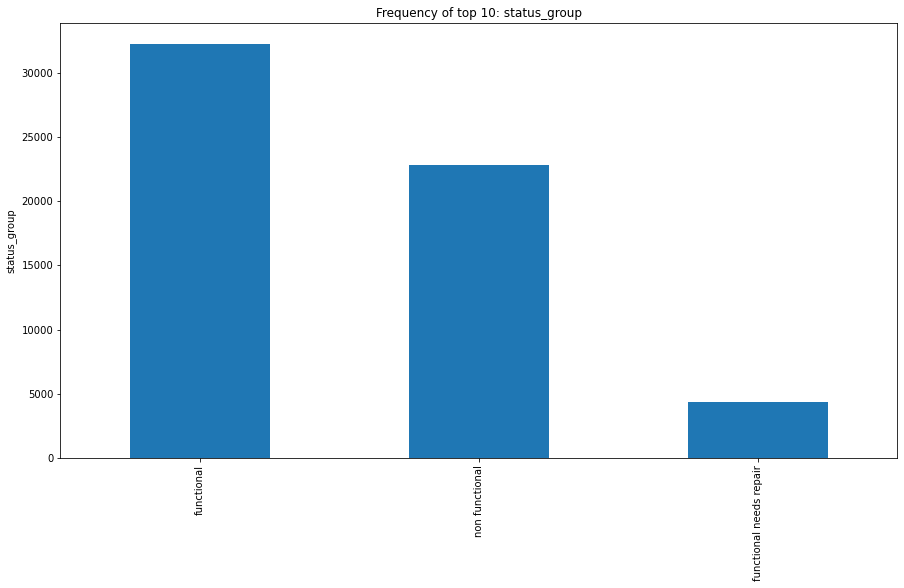

In [66]:
X = pd.read_csv('data/Training_set.csv')
y = pd.read_csv('data/Training_labels.csv').status_group
colInfo(y)

We can see this is a multi class classification problem. There is a class imbalance with the smallest class comprising of 7.26%. We might be able to overcome this by employing oversampling in some of our models.

# Train Test Split

Next, we'll use train test split to create our training and holdout sets. We shall default to the default split of 75% training and 25% validation set.

In [70]:
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [71]:
X_train.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
24947,33935,20.0,2011-03-08,Government Of Tanzania,330,Ce,38.123839,-6.087137e+00,Ccm,0,Wami / Ruvu,Kilangawageni,Pwani,6,1,Bagamoyo,Mbwewe,80,True,GeoData Consultants Ltd,VWC,Kwaruhombo wa,True,1972,ksb,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
22630,49654,0.0,2013-02-16,Dwsp,0,DWE,0.000000,-2.000000e-08,Mwamahonza,0,Lake Victoria,Mwamahala,Mwanza,17,1,Magu,Nkungulu,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
13789,39287,0.0,2011-08-13,Dasip,0,DASIP,33.312321,-2.814100e+00,Chanongu,0,Lake Victoria,Chanongu,Mwanza,19,4,Kwimba,Wala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


For more details on the columns and their distribution please refer to _Notebook_DataExploration.ipynb_ file

Lets validate our split hasn't changed the composition of the output variable

In [68]:
y_train.value_counts(normalize=True)

functional                 0.542334
non functional             0.384871
functional needs repair    0.072795
Name: status_group, dtype: float64

In [67]:
y_test.value_counts(normalize=True)

functional                 0.545320
non functional             0.382357
functional needs repair    0.072323
Name: status_group, dtype: float64

The numbers are almost identical. We are good to proceed

# Features

We shall be employing to streamline the modeling process. As part of the data exploration phase we were able to a few potential concerns. Lets look at them and address as best we can

### GPS coordinates

In [84]:
X_train[['latitude','longitude','region']].value_counts()[:5]

latitude       longitude  region       
-2.000000e-08  0.000000   Shinyanga        753
                          Mwanza           586
-6.957328e+00  37.541579  Morogoro           2
-6.991294e+00  39.085965  Dar es Salaam      2
-2.494353e+00  32.956523  Mwanza             2
dtype: int64

In [83]:
X_test[['latitude','longitude','region']].value_counts()[:5]

latitude       longitude  region   
-2.000000e-08  0.000000   Shinyanga    252
                          Mwanza       221
-2.490324e+00  32.987670  Mwanza         2
-6.963557e+00  37.543351  Morogoro       2
-2.510639e+00  32.993277  Mwanza         2
dtype: int64

In [88]:
X_train[['latitude','longitude','region']].value_counts()[:2].sum() +\
X_test[['latitude','longitude','region']].value_counts()[:2].sum()

1812

The data set has 1812 (including the both sets) records where the latitude and longitude were recorded as $(-2\times10^{-8},0)$ or effectively $(0,0)$ which is off the west coast of Africa in the Atlantic Ocean. We can as result be certain, these were either recorded in error or were not recorded at all.

We will use a custom imputer to impute these values during our pipeline operations. The imputer will look at other well sites associated with the same _region_ and impute the median coordinates for all its well sites.

As you can see above only the Mwanza and Shinyanga regions will be affected.

### construction_year

,Number,Percentage
,,
Zeroes,"15,463",34.71 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,55,0.12 %
Mean,1303.75,-
Median,1986.00,-


,Value Count,% Value Count
0,15463,34.709315
2010,2001,4.491582
2008,1959,4.397306
2009,1892,4.246914
2000,1595,3.580247
2007,1195,2.682379
2006,1103,2.475870
2003,989,2.219978
2011,943,2.116723
2012,839,1.883277


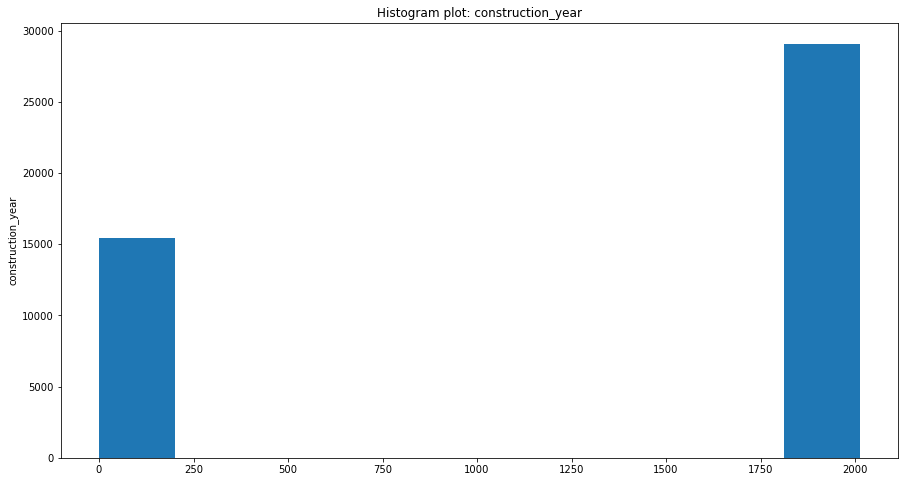

In [16]:
colInfo(X_train.construction_year)

Every well water pump has a construction year recorded defining when the site was built. However, as you can see in the training set there is a high number (34%) of zeroes. Assuming that this is an error and well water pumps were not being installed in 0AD, we shall impute these values using a simple imputer.

### Full feature list

After exploring the remaining features I've decided to use a majority of the categorical data. The final list of features being utilized are:

Numerical:
>- construction_year
>- latitude
>- longitude

Categorical:
>- region
>- public_meeting
>- scheme_management
>- permit
>- source_class
>- basin
>- extraction_type_class
>- management
>- payment
>- quality_group
>- quantity
>- source_type
>- waterpoint_type_group

### Pipelines

To streamline the process we shall be defining our pipelines here. Depending upon the feature we shall employ the appropriate pipelines. Even amongst categoricals we have a few columns that require more that one impute. 

In [89]:
#Impute nans as well as 'unknown's
subpipe_cat1 = Pipeline(steps=[
    ('cat1_imp1', SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('cat1_imp2', SimpleImputer(missing_values='unknown',strategy='most_frequent')),
    ('cat1_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#Only OneHotEncode
subpipe_cat2 = Pipeline(steps=[
    ('cat2_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#Impute median and scale (0,1)
subpipe_num = Pipeline(steps=[
    ('num_imp', SimpleImputer(missing_values=np.nan,strategy='median')),
    ('num_sc', MinMaxScaler()),    
])


#Specifically designed for imputing erroneous coordinates
#As part of your column transformations,an additional column (default='region') will be needed to be passed
#Returning dataframe excludes this additional column
#Impute (0,0) coordinates from the corresponding regions mean/median  and scale (0,1)
subpipe_coord = Pipeline(steps=[
    ('coord_imp', CoordinatesImputer(groupByTarget='region',metric='median')), 
    ('coord_sc', MinMaxScaler()),    
])

# Models

Now, that we have set up our pipelines we can finally get to modeling.

Note, that the overall metric that we will be measuring a model by is classification accuracy, or how well does the model classify across all classes. As a secondary metric we shall be looking at the F1-score, harmonic mean of precision and accuracy. 

## Baseline - Dummy Classifier

Using a dummy classifier to establish our baseline.\
Since, this classifier ignores input variables, and in the interest of time, we will not employ our column transformation pipeline.

In [13]:
baseline_00 = DummyClassifier()
baseline_00.fit(X_train,y_train)

DummyClassifier()

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saads\anaconda3\envs\learn-env\lib\site-

,Scores
,
Accuracy,0.5423
Precision,0.1808
Recall,0.3333
F1,0.2344


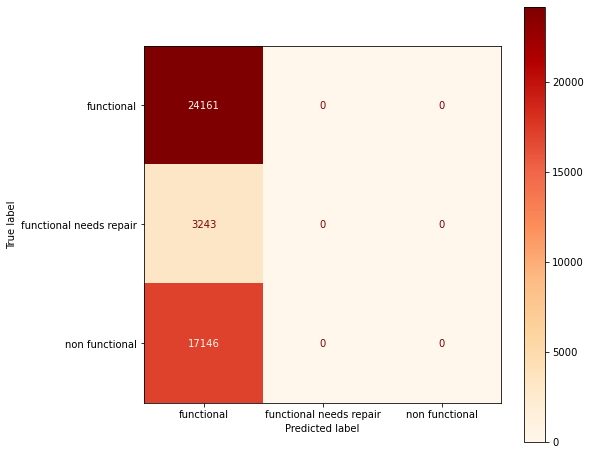

In [65]:
modelReport(baseline_00,X_train,y_train)

54% accuracy and 23% F1-score. \
The performance is rather poor as expected with the dummy classifier classifying every site as functional. However, this establishes a good baseline to compare against.

In [21]:
filePath = f'models/{baseline_00=}'.split('=')[0] + '.sav'
pickle.dump(baseline_00, open(filePath, 'wb'))

##  First Simple Model - Logistic Regression

### Simple Model

We shall employ a basic Logistic Regression model as our first model

In [17]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

,Scores
,
Accuracy,0.7279
Precision,0.6146
Recall,0.5115
F1,0.5056


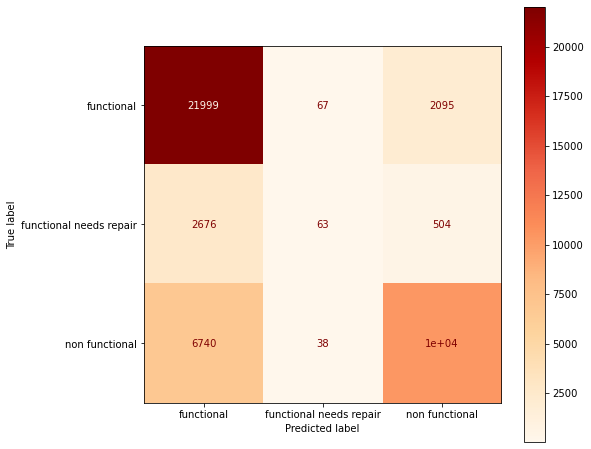

In [18]:
log_reg_pipe = Pipeline([
    ('ct', ct),
    ('log_reg', LogisticRegression(random_state=42, n_jobs=Notebook_n_jobs))
])
log_reg_pipe.fit(X_train, y_train)
modelReport(log_reg_pipe,X_train,y_train)

In [25]:
filePath = f'models/{log_reg_pipe=}'.split('=')[0] + '.sav'
pickle.dump(log_reg_pipe, open(filePath, 'wb'))

72.79% accuracy and 50.56% F1-score. \
In conjunction with our column transformer a simple logistic regression model shows massive improvements over the baseline. We can already see a massive improvement in classifying non-functional well sites.

Lets try and tune it better.

### Hypertuned Model

In [19]:
params = {}
params['log_reg__C'] = [0.1, 1, 10,100]
params['log_reg__max_iter'] = [50,100, 150,200]
params['log_reg__solver'] = ['lbfgs', 'sag']

log_reg_gs1 = GridSearchCV(estimator=log_reg_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)
log_reg_gs1.fit(X_train, y_train)

filePath = f'models/{log_reg_gs1=}'.split('=')[0] + '.sav'
pickle.dump(log_reg_gs1, open(filePath, 'wb'))

In [20]:
prettyPrintGridCVResults(log_reg_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_log_reg__C,param_log_reg__max_iter,param_log_reg__solver
Rank (By Accuracy),,,,,,,
1,0.7281,0.6077,0.5116,0.5056,10,100,lbfgs
2,0.7280,0.5880,0.5106,0.5034,100,100,lbfgs
3,0.7280,0.6137,0.5115,0.5054,1,150,lbfgs
4,0.7279,0.6137,0.5115,0.5054,1,200,lbfgs
5,0.7279,0.6137,0.5115,0.5054,1,200,sag
5,0.7279,0.6132,0.5116,0.5056,100,150,lbfgs
5,0.7279,0.6137,0.5115,0.5054,1,150,sag
5,0.7279,0.6146,0.5115,0.5056,1,100,lbfgs
9,0.7279,0.6132,0.5115,0.5054,10,200,lbfgs


Despite extensive hypertuning, it seems that the algorithm isn't able to sense the pattern all that well. We did however, see a minor bump in accuracy without loss in F1-score, with the best model showing 72.81% accuracy.

## Random Forest

Next we shall implement an ensemble algorithm, Random Forest

### Simple Model

In [42]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

,Scores
,
Accuracy,0.7869
Precision,0.6885
Recall,0.6540
F1,0.6676


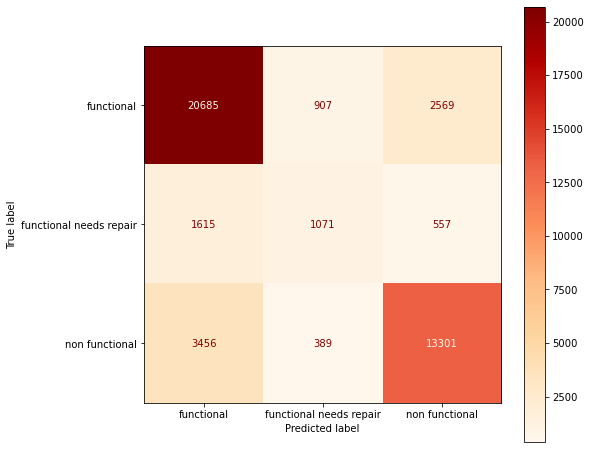

In [43]:
rfc_model_pipe = Pipeline([
    ('ct',ct),
   ('rfc',RandomForestClassifier(random_state=42,n_jobs=Notebook_n_jobs))
])

rfc_model_pipe.fit(X_train,y_train)
modelReport(rfc_model_pipe,X_train,y_train)

filePath = f'models/{rfc_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(rfc_model_pipe, open(filePath, 'wb'))

Our basic Random Forest Classifier is the best performer so far with an accuracy of 78.7% and an F1-score of 66.76%. We should be able to get more out of this modeling technique.

### Hypertuned Model

In [49]:
params = {}
params['rfc__criterion'] = ['gini','entropy']
params['rfc__n_estimators'] = [350,450,500]
params['rfc__max_depth'] = [20,23,27,30]
params['rfc__max_leaf_nodes']=[4000,4500,5000]


rfc_gs1 = GridSearchCV(estimator=rfc_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)

rfc_gs1.fit(X_train,y_train)

filePath = f'models/{rfc_gs1=}'.split('=')[0] + '.sav'
pickle.dump(rfc_gs1, open(filePath, 'wb'))

In [50]:
prettyPrintGridCVResults(rfc_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_rfc__criterion,param_rfc__max_depth,param_rfc__max_leaf_nodes,param_rfc__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7977,0.7197,0.6444,0.6675,entropy,27,4500,450
2,0.7976,0.7195,0.6444,0.6675,entropy,30,4500,500
3,0.7976,0.7197,0.6444,0.6676,entropy,27,4500,500
4,0.7975,0.7217,0.6387,0.6626,entropy,27,4000,500
5,0.7974,0.7191,0.6441,0.6671,entropy,30,4500,350
...,...,...,...,...,...,...,...,...
68,0.7947,0.7249,0.6282,0.6529,gini,20,4500,450
69,0.7946,0.7247,0.6286,0.6532,gini,20,5000,500
70,0.7945,0.7245,0.6290,0.6537,gini,20,4500,350


We increased our accuracy marginally to 79.77% with no real gain in the F1-score

,Scores
,
Accuracy,0.7977
Precision,0.7197
Recall,0.6444
F1,0.6675


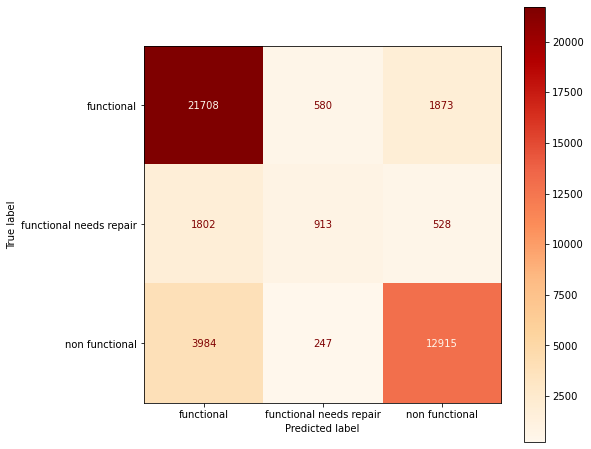

In [60]:
modelReport(rfc_gs1.best_estimator_,X_train,y_train)

It seems that the hypertuned model is having a harder time classifying wells that need repairs. Also of concern, that even when it misclassifies, is that it is more likely to classify a well that needs repairs as functional.

Barring a perfect classifying model, it'd be preferable if the model classifies it as non functional.

The imbalance in the classes is affecting the model's ability to classify each class effectively. We shall employ an undersampling technique which may help alleviate some of these issues.

### Hypertuned and SMOTE Model

We shall use the Imbalance Pipeline library and the SMOTE module. It artificially creates data points by shuffling features of similar records.

Note, that we do not SMOTE the test set. This ensures it is only used in training to help be able to predict on unseen data better.

As part of our grid search, I provided the same parameters as our hypertuned model above with one extra option of max depth for some wiggle room.

In [22]:
rfc_imb_model_pipe = ImPipeline([
    ('ct',ct),
    ('sm',SMOTE(random_state=42)),
   ('rfc',RandomForestClassifier(random_state=42))
])

In [24]:
params = {}
params['rfc__criterion'] = ['entropy']
params['rfc__n_estimators'] = [450]
params['rfc__max_depth'] = [25,30]
params['rfc__max_leaf_nodes']=[4500]

rfc_imb_gs1 = GridSearchCV(estimator=rfc_imb_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                          verbose=2)

rfc_imb_gs1.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ct_cyr',
                                                                         Pipeline(steps=[('num_imp',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('num_sc',
                                                                                          MinMaxScaler())]),
                                                                         ['construction_year']),
                                                                        ('ct_coord',
                                                                         Pipeline(steps=[('coord_imp',
                                                                                          CoordinatesImputer()),
                   

In [25]:
filePath = f'models/{rfc_imb_gs1=}'.split('=')[0] + '.sav'
pickle.dump(rfc_imb_gs1, open(filePath, 'wb'))

In [26]:
prettyPrintGridCVResults(rfc_imb_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_rfc__criterion,param_rfc__max_depth,param_rfc__max_leaf_nodes,param_rfc__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7701,0.6655,0.6989,0.6761,entropy,30,4500,450
2,0.7681,0.6636,0.6995,0.6740,entropy,25,4500,450


,Scores
,
Accuracy,0.7701
Precision,0.6655
Recall,0.6989
F1,0.6761


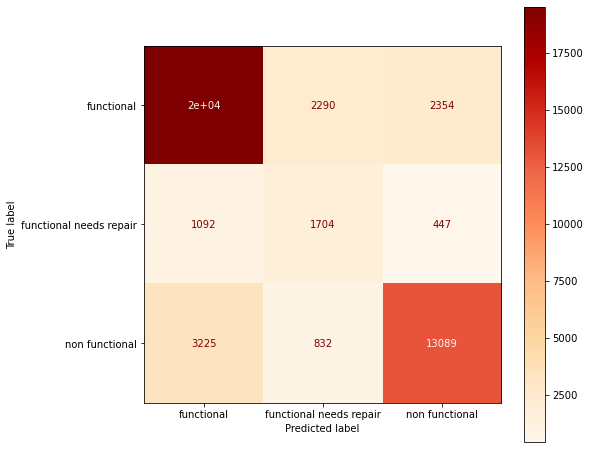

In [27]:
modelReport(rfc_imb_gs1.best_estimator_,X_train,y_train)

SMOTEing our dataset helped raise our F1-score by specifically improving predictions on water wells that need repair without much loss in accuracy. This is key in our ability to try and address a water well before failure.

## kNN

Employing k Nearest Neighbors model

### Simple Model

In [42]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

,Scores
,
Accuracy,0.7731
Precision,0.6834
Recall,0.6309
F1,0.6491


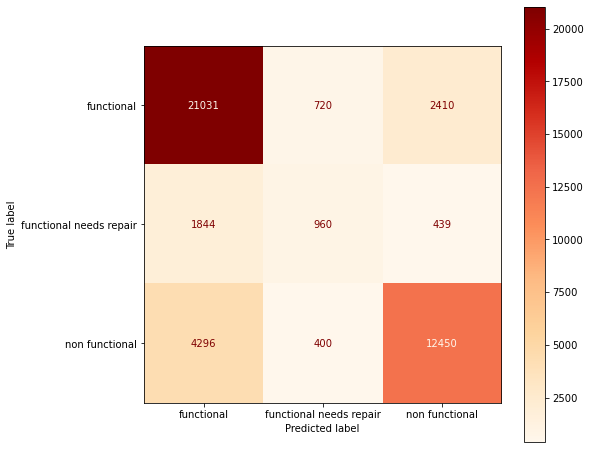

In [48]:
knn_model_pipe = Pipeline([
    ('ct',ct),
   ('knn',KNeighborsClassifier(n_jobs=Notebook_n_jobs))
])

knn_model_pipe.fit(X_train,y_train)
modelReport(knn_model_pipe,X_train,y_train)

filePath = f'models/{knn_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(knn_model_pipe, open(filePath, 'wb'))

Although a fairly similar accuracy score, the F1 score doesn't compare to the hypertuned random forest classifier. Lets try to tune this model better.

### Hypertuned kNN

In [50]:
params = {}
params['knn__n_neighbors'] = [5,10,15,20]
params['knn__metric']=['manhattan','euclidean']


knn_gs1 = GridSearchCV(estimator=knn_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                      verbose=2)

knn_gs1.fit(X_train,y_train)

filePath = f'models/{knn_gs1=}'.split('=')[0] + '.sav'
pickle.dump(knn_gs1, open(filePath, 'wb'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [51]:
prettyPrintGridCVResults(knn_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_knn__metric,param_knn__n_neighbors
Rank (By Accuracy),,,,,,
1,0.7737,0.6853,0.6285,0.6476,manhattan,5
2,0.7731,0.6834,0.6309,0.6491,euclidean,5
3,0.7668,0.6967,0.6080,0.6318,manhattan,10
4,0.7660,0.6933,0.6085,0.6318,euclidean,10
5,0.7577,0.6950,0.5931,0.6168,manhattan,15
6,0.7575,0.6928,0.5943,0.6179,euclidean,15
7,0.7527,0.6956,0.5834,0.6070,manhattan,20
8,0.7525,0.6936,0.5833,0.6068,euclidean,20


It seems that no major gains were made in accuracy or F1-score. Even though the grid search picked a value on bottom end of our n_neighbors parameter range, values less than 3 might lead to underfitting the data. I think our time may be better spent on other modeling techniques.

## XGBoost

### Simple Model

We shall employ a boosting technique next. Specifically, the xgboost module utilising the Random Forest classifier as its base.

In [46]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

In [47]:
XGBRF_model_pipe = Pipeline([
    ('ct',ct),
   ('xg',xgboost.XGBRFClassifier(random_state=42,n_jobs=Notebook_n_jobs))
])

,Scores
,
Accuracy,0.7271
Precision,0.7241
Recall,0.5113
F1,0.5151


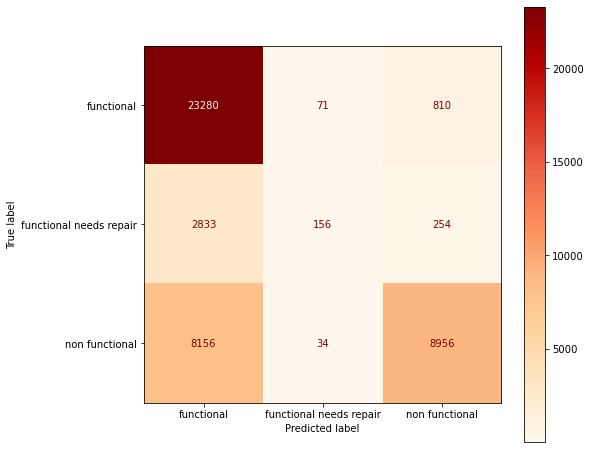

In [23]:
XGBRF_model_pipe.fit(X_train,y_train)
modelReport(XGBRF_model_pipe,X_train,y_train)

filePath = f'models/{XGBRF_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(XGBRF_model_pipe, open(filePath, 'wb'))

The baseline XGBoost is woefully under performing. However, I should have anticipated this. The default for the max_depth parameter is 6. This can lead to sever underfitting.

I believe we can tune this model to perform better. 

There are a lot more parameters that we can tweak. However, with the base model taking about 45s to compute, computational time can compound to astoronomical numbers with every extra parameter, and as a result we shall be employing hypertuning in phases.

### Hypertuned 

#### Round 1

In [24]:
params = {}
# params['xg__learning_rate'] = [0.1,1,10]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['gini','entropy']
params['xg__n_estimators'] = [350,550]
# params['xg__max_depth'] = [20,30]
params['xg__max_leaf_nodes']=[4000,5000]


xgbrf_gs1 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)

xgbrf_gs1.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs1=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs1, open(filePath, 'wb'))

[00:55:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion, max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [25]:
prettyPrintGridCVResults(xgbrf_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__max_leaf_nodes,param_xg__n_estimators
Rank (By Accuracy),,,,,,,
1,0.7264,0.7245,0.5104,0.5138,gini,4000,550
1,0.7264,0.7245,0.5104,0.5138,gini,5000,550
1,0.7264,0.7245,0.5104,0.5138,entropy,4000,550
1,0.7264,0.7245,0.5104,0.5138,entropy,5000,550
5,0.7262,0.7213,0.5104,0.5139,gini,4000,350
5,0.7262,0.7213,0.5104,0.5139,gini,5000,350
5,0.7262,0.7213,0.5104,0.5139,entropy,4000,350
5,0.7262,0.7213,0.5104,0.5139,entropy,5000,350


Per the output criterion, max_leaf_nodes might not be used. Dropping these or specifying just one value from here on out.

#### Round 2

In [36]:
params = {}
params['xg__learning_rate'] = [1,10]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
# params['xg__criterion'] = ['gini','entropy']
# params['xg__n_estimators'] = [350]
params['xg__max_depth'] = [25,30]
# params['xg__max_leaf_nodes']=[4000,5000]


xgbrf_gs2 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        verbose=2)

xgbrf_gs2.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs2=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs2, open(filePath, 'wb'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [37]:
prettyPrintGridCVResults(xgbrf_gs2)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__learning_rate,param_xg__max_depth
Rank (By Accuracy),,,,,,
1,0.7978,0.7149,0.6520,0.6729,1,25
1,0.7978,0.7149,0.6520,0.6729,10,25
3,0.7972,0.7136,0.6533,0.6736,1,30
3,0.7972,0.7136,0.6533,0.6736,10,30


As expected, by increasing the max depth we were able to drastically improve the performance of our XGBoost model. Note, that in both cases, the model with the learning rate of 1 came out on top.

So far, this is our best model with a overall accuracy of 79.78% and an F1-score of 65.2%

#### Round 3

In [38]:
params = {}
params['xg__learning_rate'] = [0.1,1,10]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['entropy']
params['xg__n_estimators'] = [450]
params['xg__max_depth'] = [27]
params['xg__max_leaf_nodes']=[4500]


xgbrf_gs3 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        verbose=2)

xgbrf_gs3.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs3=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs3, open(filePath, 'wb'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[02:16:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion, max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [39]:
prettyPrintGridCVResults(xgbrf_gs3)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__learning_rate,param_xg__max_depth,param_xg__max_leaf_nodes,param_xg__n_estimators
Rank (By Accuracy),,,,,,,,,
1,0.7971,0.7133,0.6516,0.6721,entropy,0.1,27,4500,450
1,0.7971,0.7133,0.6516,0.6721,entropy,1,27,4500,450
1,0.7971,0.7133,0.6516,0.6721,entropy,10,27,4500,450


A smaller learning rate helped improve our F1-score to 67.2% with our no major loss to our accuracy at 79.71%

#### Round 4

In [48]:
params = {}
params['xg__learning_rate'] = [0.1]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['entropy']
params['xg__n_estimators'] = [550,650]
params['xg__max_depth'] = [18,20,25]
# params['xg__max_leaf_nodes']=[4500]


xgbrf_gs4 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        verbose=3)

xgbrf_gs4.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs4=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs4, open(filePath, 'wb'))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[16:14:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [49]:
prettyPrintGridCVResults(xgbrf_gs4)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__learning_rate,param_xg__max_depth,param_xg__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7992,0.7243,0.6474,0.6711,entropy,0.1,20,550
2,0.7991,0.7243,0.6475,0.6712,entropy,0.1,20,650
3,0.7986,0.7295,0.6425,0.6679,entropy,0.1,18,650
4,0.7985,0.7292,0.6426,0.6679,entropy,0.1,18,550
5,0.7979,0.7161,0.6516,0.6729,entropy,0.1,25,650
6,0.7978,0.7158,0.6517,0.6729,entropy,0.1,25,550


I decided to hold the learning rate static at the previously tested 0.1 and give the grid search a little more flexibility to choose its max depth.

This is so far our best model with an overall accuracy of 79.92 % and an F1-score of 67.11%

### Hypertuned and SMOTE model

#### Round 1

We will use the params  from our best estimator to see whether SMOTEing the data will improve the outcome

In [121]:
XGBRF_sm_model_pipe = ImPipeline([
    ('ct',ct),
    ('sm',SMOTE(random_state=42)),
   ('xg',xgboost.XGBRFClassifier(random_state=42))
])

In [122]:
params = {}
params['xg__learning_rate'] = [0.1]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['entropy']
params['xg__n_estimators'] = [550]
params['xg__max_depth'] = [18,22]
# params['xg__max_leaf_nodes']=[4500]


xgbrf_imb_gs1 = GridSearchCV(estimator=XGBRF_sm_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        )

xgbrf_imb_gs1.fit(X_train,y_train)

[00:39:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ct_cyr',
                                                                         Pipeline(steps=[('num_imp',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('num_sc',
                                                                                          MinMaxScaler())]),
                                                                         ['construction_year']),
                                                                        ('ct_coord',
                                                                         Pipeline(steps=[('coord_imp',
                                                                                          CoordinatesImputer()),
                   

In [123]:
filePath = f'models/{xgbrf_imb_gs1=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_imb_gs1, open(filePath, 'wb'))

In [39]:
prettyPrintGridCVResults(xgbrf_imb_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__learning_rate,param_xg__max_depth,param_xg__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7711,0.6654,0.6987,0.6763,entropy,0.1,22,550
2,0.7629,0.6596,0.7019,0.6704,entropy,0.1,18,550


SMOTE seems to have adversely affected our overall accuracy for a minor gain in F1-score. More research is needed. We shall give the grid search a few more parameters to play with.

#### Round 2

In [56]:
params = {}
params['xg__learning_rate'] = [0.1]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['entropy']
params['xg__n_estimators'] = [700,800,900]
params['xg__max_depth'] = [30,35,40]
# params['xg__max_leaf_nodes']=[4500]


xgbrf_imb_gs2 = GridSearchCV(estimator=XGBRF_sm_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        verbose=3)

xgbrf_imb_gs2.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[21:03:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ct_cyr',
                                                                         Pipeline(steps=[('num_imp',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('num_sc',
                                                                                          MinMaxScaler())]),
                                                                         ['construction_year']),
                                                                        ('ct_coord',
                                                                         Pipeline(steps=[('coord_imp',
                                                                                          CoordinatesImputer()),
                   

In [57]:
filePath = f'models/{xgbrf_imb_gs2=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_imb_gs2, open(filePath, 'wb'))

In [58]:
prettyPrintGridCVResults(xgbrf_imb_gs2)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__learning_rate,param_xg__max_depth,param_xg__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7746,0.6674,0.6927,0.6767,entropy,0.1,30,700
2,0.7745,0.6669,0.6916,0.6761,entropy,0.1,35,700
3,0.7745,0.6669,0.6913,0.6759,entropy,0.1,40,700
4,0.7744,0.6669,0.6913,0.6759,entropy,0.1,35,900
5,0.7744,0.6669,0.6915,0.6760,entropy,0.1,40,800
6,0.7744,0.6672,0.6924,0.6764,entropy,0.1,30,900
7,0.7743,0.6671,0.6925,0.6764,entropy,0.1,30,800
7,0.7743,0.6669,0.6912,0.6759,entropy,0.1,40,900
9,0.7743,0.6669,0.6916,0.6760,entropy,0.1,35,800


Our accuracy and F1-scores are still not enough to warrant using this model. Reducing our max depth for one last variation just to sate my curiosity.

### Final Model

We shall use the model that we got from our Round 4 of the hypertuning of the XGBoost model. We shall see how it performs against our test/holdout set

In [98]:
final_model =  pickle.load(open(f'models/xgbrf_gs4.sav', 'rb')).best_estimator_

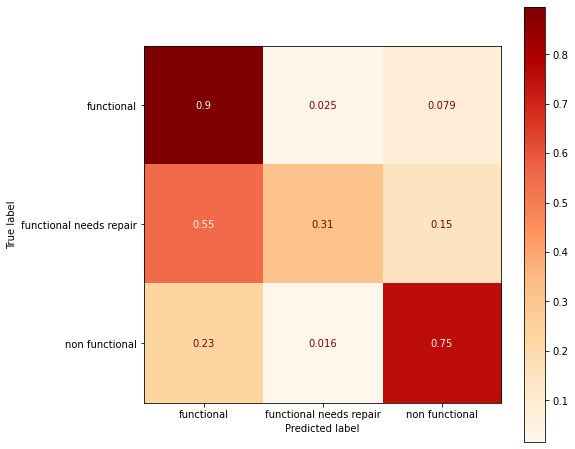

In [110]:
fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay.from_estimator(
        final_model,
        X_test,
        y_test,
        display_labels=final_model.classes_,
        cmap='OrRd',
        normalize='true',
        ax=ax
    )

We can tell that overall our model is able to predict a functional and a non functional well site fairly well. It still has difficulties classifying a site that needs repairs

In [115]:
final_model.score(X_test, y_test)

0.7995286195286195

In [45]:
print(classification_report(y_test,preds))

                         precision    recall  f1-score   support

             functional       0.79      0.90      0.84      8098
functional needs repair       0.53      0.31      0.39      1074
         non functional       0.84      0.75      0.80      5678

               accuracy                           0.80     14850
              macro avg       0.72      0.65      0.68     14850
           weighted avg       0.79      0.80      0.79     14850



In terms of metrics the model has an overall accuracy of 80%.
F1 scores for functional sites are 84%
F1 scores for non functional sites are 80%
F1 scores for functional sites that need repair is 39%

We will need to address the class imbalance within the dataset to improve our over all performance. If more data was available for such sites the model performance would improve.
We can also try to fine tune our SMOTE models, or employ more elaborate stacking and boosting algorithms.